# Dataset

In [1]:
import sys
sys.path.append('../datasets/')
from prepare_individuals import prepare, classes13, classes18
import matplotlib.pyplot as plt

classes = classes18

In [2]:
patch_len = 44                               # = 250ms ~ 25ms

X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare("../datasets/prepared.h5", classes, patch_len, ml=True, threshold=0)

100%|███████████████████████████████████████████| 18/18 [01:03<00:00,  3.51s/it]


In [3]:
print("Total calls:", len(X_train) + len(X_test) + len(X_val))
print(X_train.shape, Y_train.shape)

Total calls: 31186
(18226, 44, 257) (18226,)


# Model

In [4]:
import time
import datetime
import numpy as np
import tqdm
import torch
import torch.nn as nn
import torchvision
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader

In [5]:
use_stochdepth = True
use_mixedprecision = False
use_sampler = False
use_cosinescheduler = False
use_reduceonplateu = True
use_nadam = False

In [6]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
            
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x = torchvision.ops.stochastic_depth(input=x, p=0.25, mode='batch', training=self.training)  # randomly zero input tensor
        x += identity
        x = self.relu(x)
        return x

In [7]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

In [8]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
         
        # Clear the gradients
        optimizer.zero_grad()
        
        with autocast(enabled=use_mixedprecision):
            # Forward Pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Compute Loss
            loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights
        optimizer.step()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (predictions == labels).sum().item()
        
        # Perform learning rate step
        if use_cosinescheduler:
            scheduler.step(epoch + batch / num_batches)
    
    epoch_loss = running_loss / num_samples
    epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [9]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Update Weights
            optimizer.step()

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (predictions == labels).sum().item()

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [10]:
from torchsampler import ImbalancedDatasetSampler

batch_size = 64
epochs = 50
lr = 0.01
warmup_epochs = 5
wd = 0.01

'''# Experiment: wrong sampling
X = np.concatenate([X_train, X_test, X_val])
Y = np.concatenate([Y_train, Y_test, Y_val])

full_data = TensorDataset(torch.Tensor(np.expand_dims(X, axis=1)), torch.from_numpy(Y))
train_size = int(0.75 * len(full_data))
test_size = len(full_data) - train_size
val_size = int(0.2 * test_size)
test_size -= val_size

train_data, test_data, val_data = torch.utils.data.random_split(full_data, [train_size, test_size, val_size],
                                                                generator=torch.Generator().manual_seed(42))'''

train_data = TensorDataset(torch.Tensor(np.expand_dims(X_train, axis=1)), torch.from_numpy(Y_train))
test_data = TensorDataset(torch.Tensor(np.expand_dims(X_test, axis=1)), torch.from_numpy(Y_test))
val_data = TensorDataset(torch.Tensor(np.expand_dims(X_val, axis=1)), torch.from_numpy(Y_val))

if use_sampler:
    train_loader = DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data), batch_size=batch_size)
    test_loader = DataLoader(test_data, sampler=ImbalancedDatasetSampler(test_data), batch_size=batch_size)
    val_loader = DataLoader(val_data, sampler=ImbalancedDatasetSampler(val_data), batch_size=batch_size)
else:
    train_loader = DataLoader(train_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    val_loader = DataLoader(val_data, batch_size=batch_size)

In [11]:
model = ResNet(50, Block, image_channels=1, num_classes=len(list(classes)))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
model.to(device)
print(device)

cuda:0


In [12]:
import wandb

wandb.init(project="BAT-baseline", entity="frankfundel")

wandb.config = {
  "learning_rate": lr,
  "epochs": epochs,
  "batch_size": batch_size
}

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
if use_nadam:
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr, weight_decay=wd)

scheduler = None
if use_cosinescheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=warmup_epochs, T_mult=1)
if use_reduceonplateu:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss, train_acc = train_epoch(model, epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc), flush=True)
    
    val_loss, val_acc = test_epoch(model, epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc), flush=True)
    
    if use_reduceonplateu:
        scheduler.step(val_loss)
    
    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
         
        # Saving State Dict
        torch.save(model.state_dict(), 'baseline.pth')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frankfundel (use `wandb login --relogin` to force relogin)


==================== Starting at epoch 0 ====================


100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.75it/s]

Training loss: 2.4310 Acc: 0.3070



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.09it/s]

Validation loss: 2.1297 Acc: 0.3668
val_loss decreased, saving model


==================== Starting at epoch 1 ====================


100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.76it/s]

Training loss: 1.6526 Acc: 0.4810



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.09it/s]

Validation loss: 1.5502 Acc: 0.5144
val_loss decreased, saving model


==================== Starting at epoch 2 ====================


100%|█████████████████████████████████████████| 285/285 [01:44<00:00,  2.73it/s]

Training loss: 1.2906 Acc: 0.5805



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.08it/s]

Validation loss: 1.2855 Acc: 0.5733
val_loss decreased, saving model


==================== Starting at epoch 3 ====================


100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.74it/s]

Training loss: 1.0763 Acc: 0.6424



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.02it/s]

Validation loss: 1.2276 Acc: 0.5777
val_loss decreased, saving model


==================== Starting at epoch 4 ====================


100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.74it/s]

Training loss: 0.9496 Acc: 0.6839



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.04it/s]

Validation loss: 1.0585 Acc: 0.6292
val_loss decreased, saving model


==================== Starting at epoch 5 ====================


100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.74it/s]

Training loss: 0.8401 Acc: 0.7167



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.01it/s]

Validation loss: 1.2964 Acc: 0.5588
==================== Starting at epoch 6 ====================



100%|█████████████████████████████████████████| 285/285 [01:44<00:00,  2.74it/s]

Training loss: 0.7731 Acc: 0.7387



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.06it/s]

Validation loss: 0.9222 Acc: 0.6785
val_loss decreased, saving model


==================== Starting at epoch 7 ====================


100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.74it/s]

Training loss: 0.7152 Acc: 0.7540



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.03it/s]

Validation loss: 1.0127 Acc: 0.6527
==================== Starting at epoch 8 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.76it/s]

Training loss: 0.6954 Acc: 0.7605



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.09it/s]

Validation loss: 0.9406 Acc: 0.6887
==================== Starting at epoch 9 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.76it/s]

Training loss: 0.6371 Acc: 0.7786



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.06it/s]

Validation loss: 0.8359 Acc: 0.7126
val_loss decreased, saving model


==================== Starting at epoch 10 ====================


100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.77it/s]

Training loss: 0.6100 Acc: 0.7881



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.06it/s]

Validation loss: 0.8584 Acc: 0.7189
==================== Starting at epoch 11 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.77it/s]

Training loss: 0.5535 Acc: 0.8059



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.06it/s]

Validation loss: 0.7468 Acc: 0.7407
val_loss decreased, saving model


==================== Starting at epoch 12 ====================


100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.77it/s]

Training loss: 0.5273 Acc: 0.8163



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.09it/s]

Validation loss: 0.8468 Acc: 0.7160
==================== Starting at epoch 13 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.76it/s]

Training loss: 0.4993 Acc: 0.8294



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.04it/s]

Validation loss: 0.7923 Acc: 0.7384
==================== Starting at epoch 14 ====================



100%|█████████████████████████████████████████| 285/285 [01:42<00:00,  2.77it/s]

Training loss: 0.4861 Acc: 0.8278



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.04it/s]

Validation loss: 0.7387 Acc: 0.7592
val_loss decreased, saving model


==================== Starting at epoch 15 ====================


100%|█████████████████████████████████████████| 285/285 [01:42<00:00,  2.78it/s]

Training loss: 0.4585 Acc: 0.8443



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.05it/s]

Validation loss: 0.7726 Acc: 0.7462
==================== Starting at epoch 16 ====================



100%|█████████████████████████████████████████| 285/285 [01:42<00:00,  2.77it/s]

Training loss: 0.4241 Acc: 0.8522



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.10it/s]

Validation loss: 0.8510 Acc: 0.7443
==================== Starting at epoch 17 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.77it/s]

Training loss: 0.4245 Acc: 0.8506



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.09it/s]

Validation loss: 0.8052 Acc: 0.7619
==================== Starting at epoch 18 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.75it/s]

Training loss: 0.3990 Acc: 0.8616



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.06it/s]

Validation loss: 0.8280 Acc: 0.7627
==================== Starting at epoch 19 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.74it/s]

Training loss: 0.3760 Acc: 0.8669



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.04it/s]

Validation loss: 0.8641 Acc: 0.7504
==================== Starting at epoch 20 ====================



100%|█████████████████████████████████████████| 285/285 [01:44<00:00,  2.74it/s]

Training loss: 0.3731 Acc: 0.8699



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.05it/s]

Validation loss: 0.8693 Acc: 0.7393
==================== Starting at epoch 21 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.74it/s]

Training loss: 0.3211 Acc: 0.8871



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.05it/s]

Validation loss: 0.8178 Acc: 0.7648
==================== Starting at epoch 22 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.74it/s]

Training loss: 0.3238 Acc: 0.8887



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.02it/s]

Validation loss: 0.9003 Acc: 0.7600
==================== Starting at epoch 23 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.74it/s]

Training loss: 0.2915 Acc: 0.8975



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.02it/s]

Validation loss: 0.8655 Acc: 0.7730
==================== Starting at epoch 24 ====================



100%|█████████████████████████████████████████| 285/285 [01:44<00:00,  2.74it/s]

Training loss: 0.2977 Acc: 0.8945



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.00it/s]

Validation loss: 0.9908 Acc: 0.7441
==================== Starting at epoch 25 ====================



100%|█████████████████████████████████████████| 285/285 [01:44<00:00,  2.74it/s]

Training loss: 0.2803 Acc: 0.9023



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 16.88it/s]

Validation loss: 0.8819 Acc: 0.7615
==================== Starting at epoch 26 ====================



100%|█████████████████████████████████████████| 285/285 [01:44<00:00,  2.74it/s]

Training loss: 0.2332 Acc: 0.9217



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.00it/s]

Validation loss: 0.7811 Acc: 0.7829
==================== Starting at epoch 27 ====================



100%|█████████████████████████████████████████| 285/285 [01:46<00:00,  2.67it/s]

Training loss: 0.2255 Acc: 0.9255



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.02it/s]

Validation loss: 0.7743 Acc: 0.7889
==================== Starting at epoch 28 ====================



100%|█████████████████████████████████████████| 285/285 [01:47<00:00,  2.65it/s]

Training loss: 0.2004 Acc: 0.9350



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 16.35it/s]

Validation loss: 0.7880 Acc: 0.7789
==================== Starting at epoch 29 ====================



100%|█████████████████████████████████████████| 285/285 [01:45<00:00,  2.71it/s]

Training loss: 0.2032 Acc: 0.9344



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.02it/s]

Validation loss: 0.7776 Acc: 0.7894
==================== Starting at epoch 30 ====================



100%|█████████████████████████████████████████| 285/285 [01:46<00:00,  2.68it/s]

Training loss: 0.2126 Acc: 0.9326



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 16.38it/s]

Validation loss: 0.7937 Acc: 0.7914
==================== Starting at epoch 31 ====================



100%|█████████████████████████████████████████| 285/285 [01:45<00:00,  2.71it/s]

Training loss: 0.1971 Acc: 0.9360



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.06it/s]

Validation loss: 0.7910 Acc: 0.7850
==================== Starting at epoch 32 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.76it/s]

Training loss: 0.1966 Acc: 0.9366



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.04it/s]

Validation loss: 0.8007 Acc: 0.7843
==================== Starting at epoch 33 ====================



100%|█████████████████████████████████████████| 285/285 [01:47<00:00,  2.66it/s]

Training loss: 0.1812 Acc: 0.9419



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 16.37it/s]

Validation loss: 0.8013 Acc: 0.7860
==================== Starting at epoch 34 ====================



100%|█████████████████████████████████████████| 285/285 [01:45<00:00,  2.71it/s]

Training loss: 0.1851 Acc: 0.9403



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.03it/s]

Validation loss: 0.8105 Acc: 0.7902
==================== Starting at epoch 35 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.74it/s]

Training loss: 0.1748 Acc: 0.9441



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.01it/s]

Validation loss: 0.8206 Acc: 0.7808
==================== Starting at epoch 36 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.75it/s]

Training loss: 0.2037 Acc: 0.9353



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 16.99it/s]

Validation loss: 0.8379 Acc: 0.7925
==================== Starting at epoch 37 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.75it/s]

Training loss: 0.1667 Acc: 0.9481



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.00it/s]

Validation loss: 0.7777 Acc: 0.7877
==================== Starting at epoch 38 ====================



100%|█████████████████████████████████████████| 285/285 [01:47<00:00,  2.65it/s]

Training loss: 0.1911 Acc: 0.9416



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 16.35it/s]

Validation loss: 0.8145 Acc: 0.7822
==================== Starting at epoch 39 ====================



100%|█████████████████████████████████████████| 285/285 [01:47<00:00,  2.65it/s]

Training loss: 0.1643 Acc: 0.9483



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 16.35it/s]

Validation loss: 0.8338 Acc: 0.7841
==================== Starting at epoch 40 ====================



100%|█████████████████████████████████████████| 285/285 [01:47<00:00,  2.65it/s]

Training loss: 0.1506 Acc: 0.9508



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 16.33it/s]

Validation loss: 0.8803 Acc: 0.7701
==================== Starting at epoch 41 ====================



100%|█████████████████████████████████████████| 285/285 [01:47<00:00,  2.65it/s]

Training loss: 0.1730 Acc: 0.9441



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 16.33it/s]

Validation loss: 0.8076 Acc: 0.7898
==================== Starting at epoch 42 ====================



100%|█████████████████████████████████████████| 285/285 [01:47<00:00,  2.65it/s]

Training loss: 0.1703 Acc: 0.9460



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 16.33it/s]

Validation loss: 0.8078 Acc: 0.7921
==================== Starting at epoch 43 ====================



100%|█████████████████████████████████████████| 285/285 [01:47<00:00,  2.65it/s]

Training loss: 0.1723 Acc: 0.9442



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 16.33it/s]

Validation loss: 0.8404 Acc: 0.7891
==================== Starting at epoch 44 ====================



100%|█████████████████████████████████████████| 285/285 [01:46<00:00,  2.69it/s]

Training loss: 0.1640 Acc: 0.9492



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.01it/s]

Validation loss: 0.7951 Acc: 0.7877
==================== Starting at epoch 45 ====================



100%|█████████████████████████████████████████| 285/285 [01:43<00:00,  2.77it/s]

Training loss: 0.1757 Acc: 0.9423



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.03it/s]

Validation loss: 0.8281 Acc: 0.7940
==================== Starting at epoch 46 ====================



100%|█████████████████████████████████████████| 285/285 [01:42<00:00,  2.77it/s]

Training loss: 0.1747 Acc: 0.9466



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.05it/s]

Validation loss: 0.8456 Acc: 0.7854
==================== Starting at epoch 47 ====================



100%|█████████████████████████████████████████| 285/285 [01:42<00:00,  2.77it/s]

Training loss: 0.1648 Acc: 0.9486



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.04it/s]

Validation loss: 0.8411 Acc: 0.7845
==================== Starting at epoch 48 ====================



100%|█████████████████████████████████████████| 285/285 [01:42<00:00,  2.77it/s]

Training loss: 0.1852 Acc: 0.9432



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 17.02it/s]

Validation loss: 0.8081 Acc: 0.7852
==================== Starting at epoch 49 ====================



100%|█████████████████████████████████████████| 285/285 [01:45<00:00,  2.70it/s]

Training loss: 0.1636 Acc: 0.9484



100%|███████████████████████████████████████████| 75/75 [00:04<00:00, 16.34it/s]

Validation loss: 0.7854 Acc: 0.7946


In [13]:
compiled_model = torch.jit.script(model)
torch.jit.save(compiled_model, 'baseline.pt')

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
        output = model(inputs.cuda()) # Feed Network
        
        output = (torch.max(output, 1)[1]).data.cpu().numpy()
        Y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        Y_true.extend(labels) # Save Truth

100%|█████████████████████████████████████████| 128/128 [00:41<00:00,  3.11it/s]


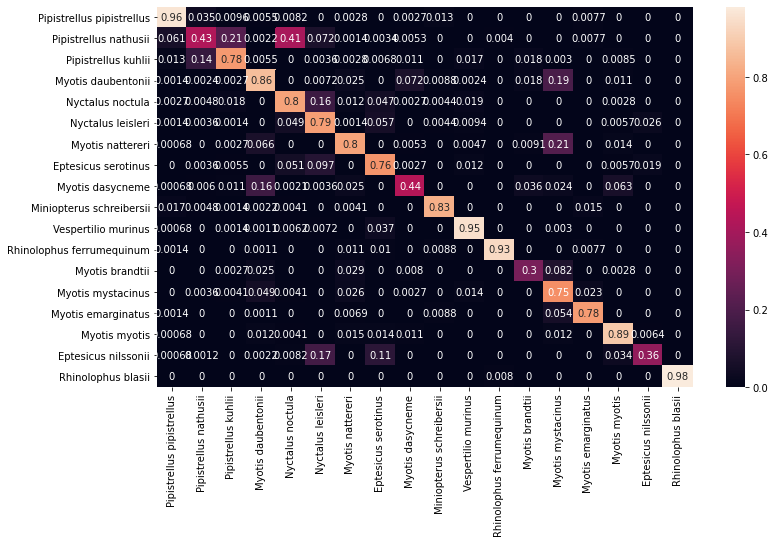

In [15]:
# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=-1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('baseline_cf.png')

In [16]:
corrects = np.equal(Y_pred, Y_true).sum()
print("Test accuracy:", corrects/len(Y_pred))

Test accuracy: 0.7804371718158505


wandb: Network error (ReadTimeout), entering retry loop.
